# Image Processing

Our book images has two pages per image. The images are also very large and contain several white spaces.
We want to 

In [19]:
import layoutparser as lp

import matplotlib.pyplot as plt

%matplotlib inline
from pdf2image import convert_from_path

import numpy as np
import pandas as pd

from sklearn.cluster import DBSCAN
from sklearn import metrics
import seaborn as sns


from tqdm import tqdm

In [4]:
images = convert_from_path('/home/davibarreira/Desktop/qdoc.tips_soares-glaucio-ary-dillon-a-democracia-interrompid.pdf')

In [5]:
x = images[5]
img = np.array(x)


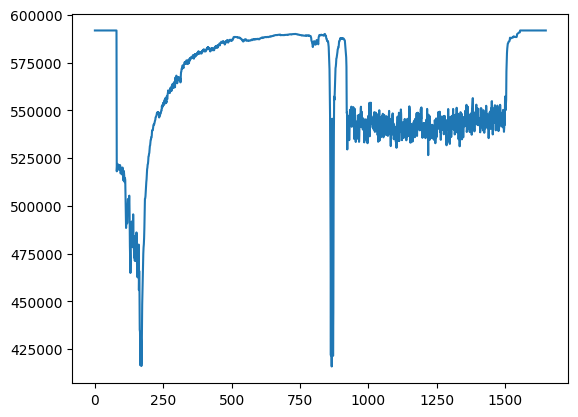

In [6]:
r,g,b = img.transpose((2,0,1))

plt.plot(np.sum(r+g+b,axis=0))

In [117]:
h = np.sum(r+g+b,axis=0)
hbreak1 = np.argmin(h[0:500])
hbreak2 = np.argmin(h[500:1200])+500
hbreak3 = x.size[0]

v = np.sum(r+g+b,axis=1)
vbreak = np.argmax(v[500:]) + 500

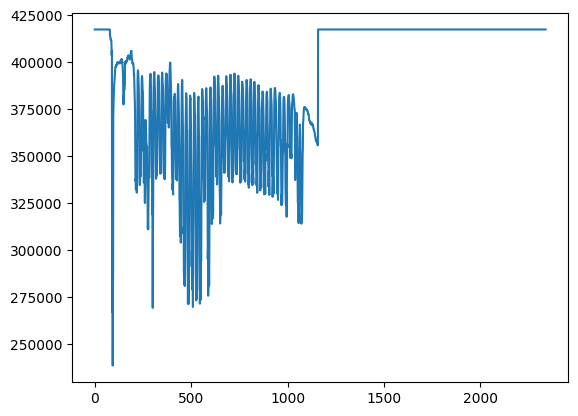

In [118]:
plt.plot(np.sum(r+g+b,axis=1))

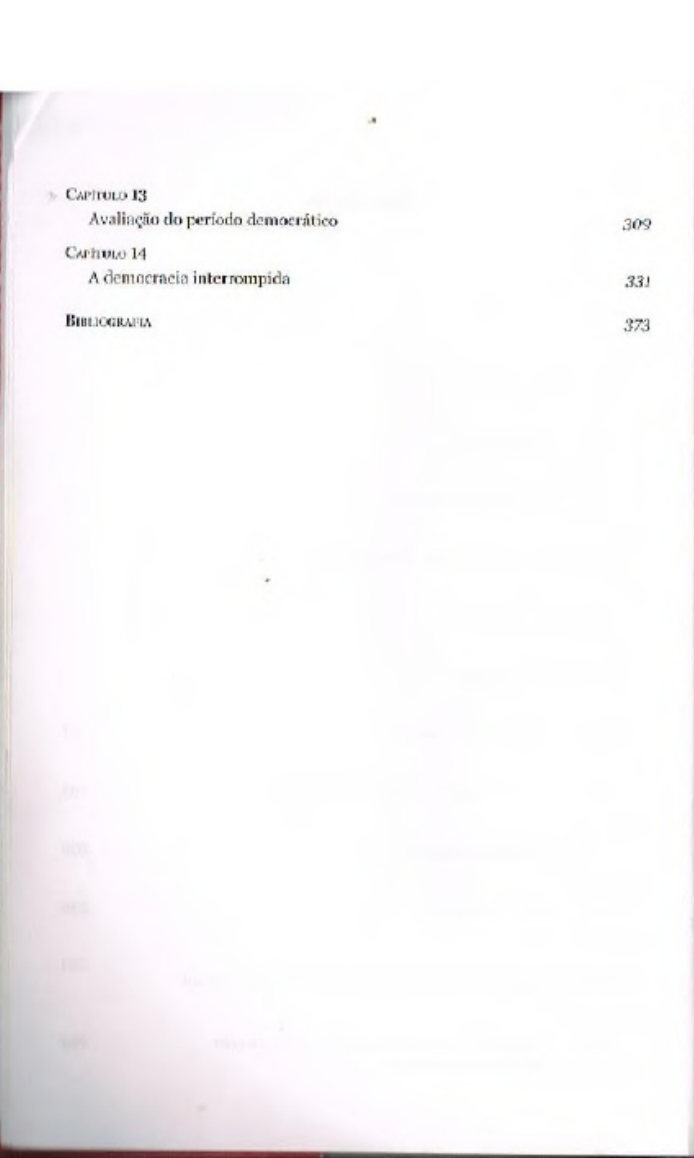

In [119]:
page1 = x.crop(box=(hbreak1,0,hbreak2,vbreak))
page1

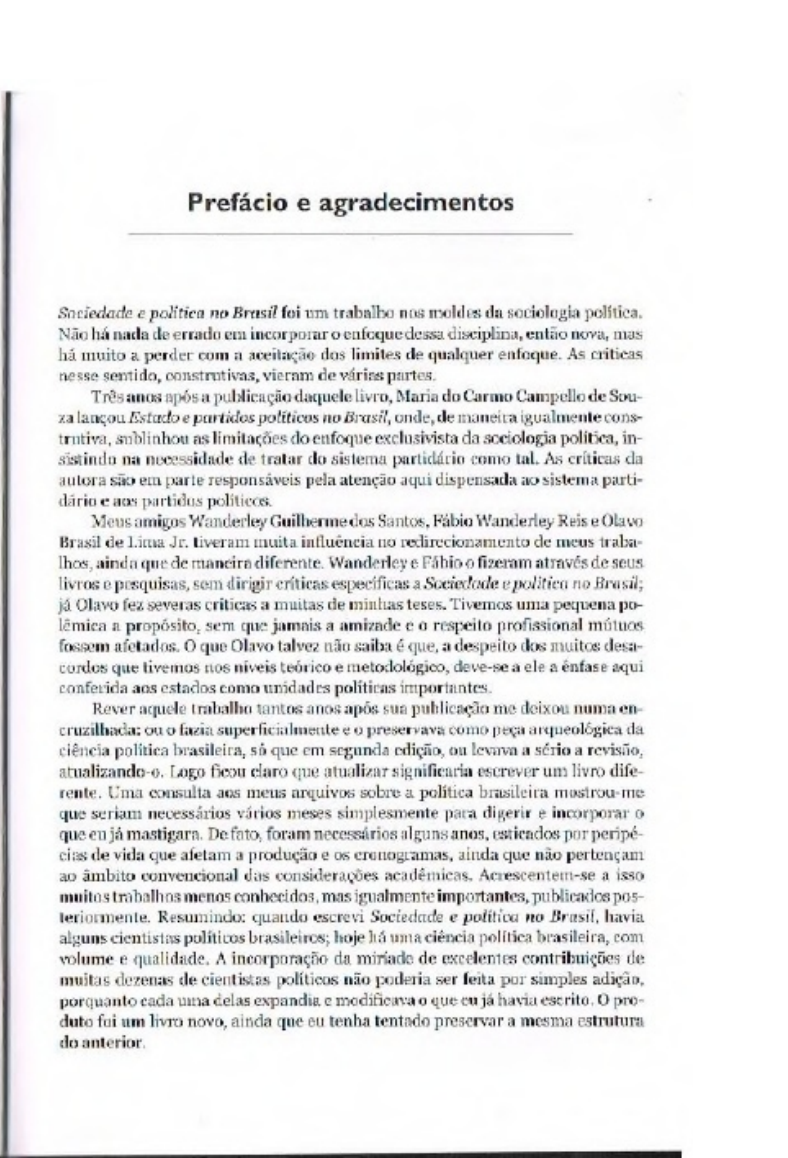

In [120]:
page2 = x.crop(box=(hbreak2,0,hbreak3,vbreak))

page2

In [121]:
page2.size

(788, 1158)

## Saving Images

In [122]:
def crop_image(image):
    img = np.array(image)
    r,g,b = img.transpose((2,0,1))
    
    h = np.sum(r+g+b,axis=0)
    hbreak1 = np.argmin(h[0:500])
    hbreak2 = np.argmin(h[500:1200])+500
    hbreak3 = image.size[0]

    v = np.sum(r+g+b,axis=1)
    vbreak = np.argmax(v[500:]) + 500
    page1 = image.crop(box=(hbreak1,0,hbreak2,vbreak))
    page2 = image.crop(box=(hbreak2,0,hbreak3,vbreak))
    
    return page1, page2

In [219]:
for image, i in tqdm(zip(images[5:-2],range(5,len(images[5:-2])*2)[::2])):
    page1, page2 = crop_image(image)
    page1.save('./images/img'+str(i)+'.png')
    page2.save('./images/img'+str(i+1)+'.png')

185it [01:19,  2.32it/s]


The checkpoint state_dict contains keys that are not used by the model:
  pixel_mean
  pixel_std
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


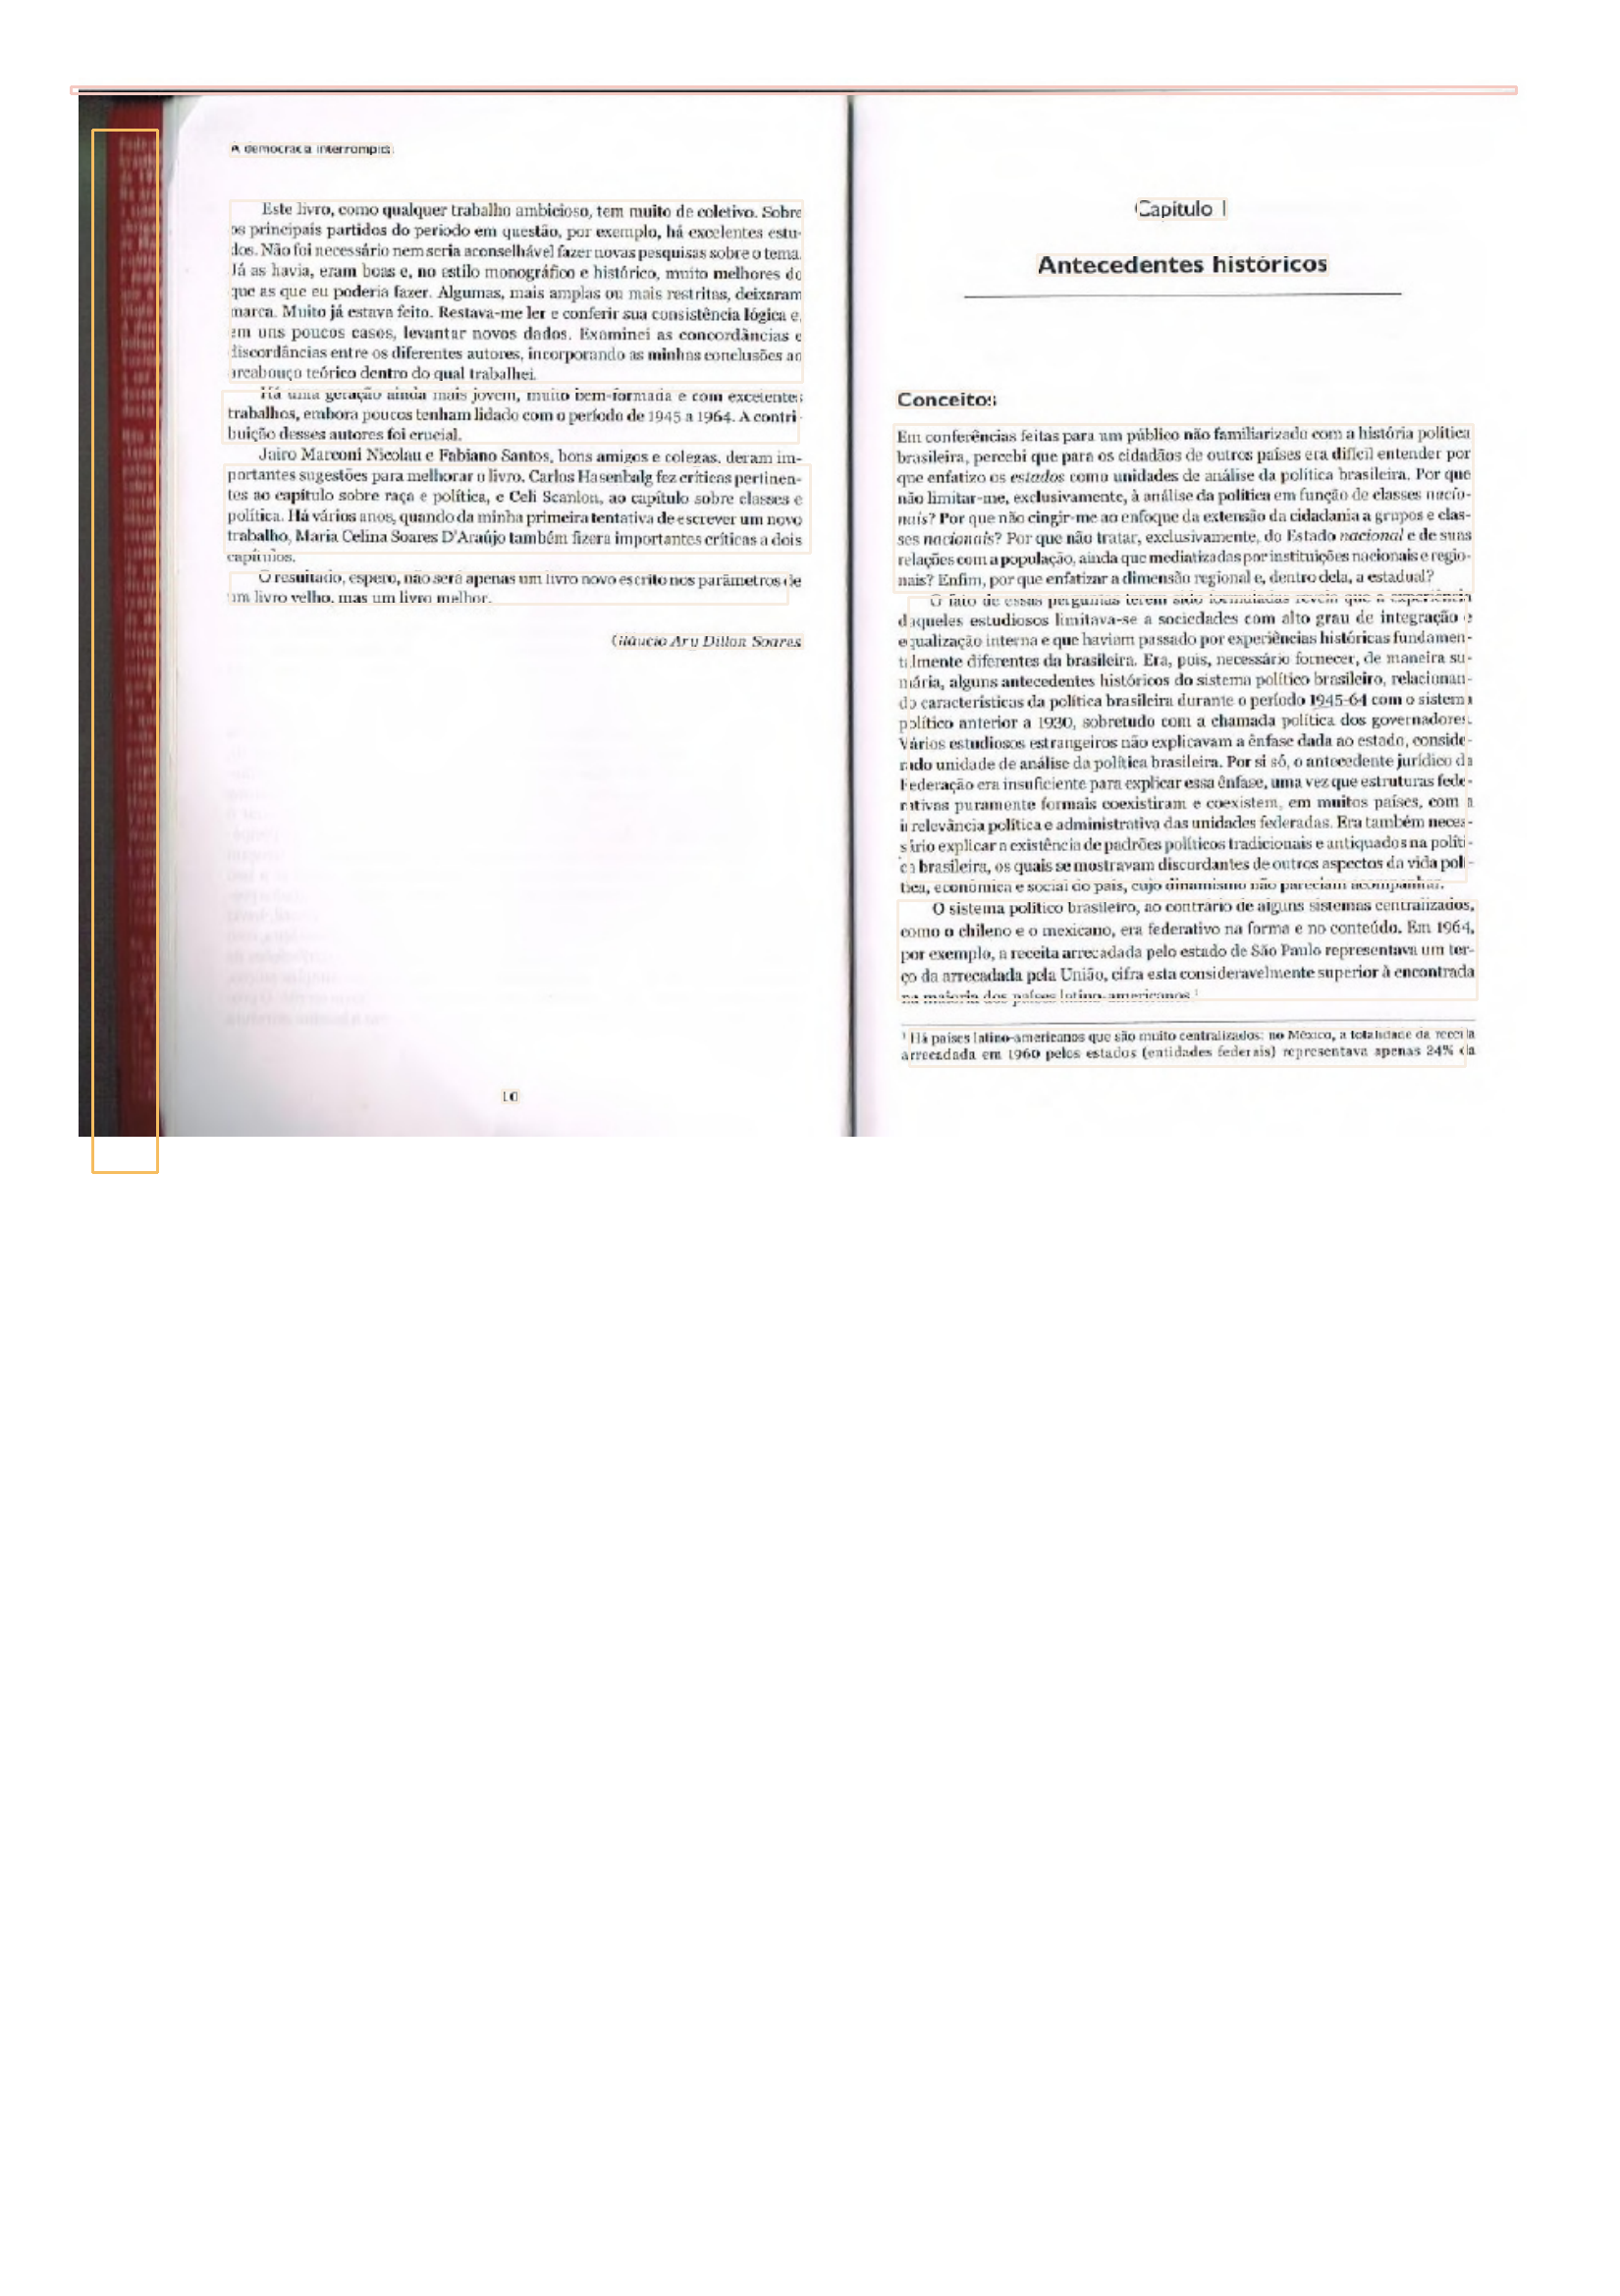

In [218]:
image = images[6]

# r,g,b = np.array(image).transpose((2,0,1))
# h = np.sum(r+g+b,axis=0)
# hbreak1 = np.argmin(h[0:500])
# hbreak2 = np.argmin(h[500:1200])+500
# hbreak3 = image.size[0]

# v = np.sum(r+g+b,axis=1)
# vbreak = np.argmin(v)
# page1 = image.crop(box=(hbreak1,0,hbreak2,vbreak))
# page2 = image.crop(box=(hbreak2,0,hbreak3,vbreak))
# plt.plot(v)
# crop_image(image)[1]

# hbreak2
# image.crop(box)
# image.crop
# box=(hbreak1,0,hbreak2,vbreak)

model = lp.Detectron2LayoutModel(
            config_path ='lp://PrimaLayout/mask_rcnn_R_50_FPN_3x/config', # In model catalog
            label_map   ={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"}, # In model`label_map`
            extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.7] # Optional
        )
layout = model.detect(image)
lp.draw_box(image, layout, box_width=3)

185it [01:21,  2.28it/s]


## Testing with OCR

In [12]:
ocr_agent = lp.TesseractAgent(languages='por')

res = ocr_agent.detect(page2, return_response=True)
layout = ocr_agent.gather_data(res, agg_level=lp.TesseractFeatureType.WORD)

In [13]:
dl = layout.to_dataframe()

In [14]:
from spellchecker import SpellChecker

In [15]:
pt = SpellChecker(language='pt')

In [16]:
def correct_word(word):
    if not(word.isalpha()):
        return word
    
    corr = pt.correction(word)
    if corr is None:
        return word
    elif word.isupper():
        return corr.upper()
    elif word.istitle():
        return corr.title()
    return word

In [22]:
dl['correct_text'] = dl.text.apply(correct_word)

In [27]:
dl[(dl['score'] > 0) & (dl.score < 80)]

x_1  y_1  x_2   y_2 block_type        text   id  score correct_text
10    54  305  128   319  rectangle   Snciedade   10   78.0    Sociedade
15   278  305  296   319  rectangle         foi   15   60.0          foi
16   301  310  325   318  rectangle          vm   16   35.0           vm
17   330  305  390   319  rectangle    trabalho   17   45.0     trabalho
21   504  305  576   322  rectangle  sociolugia   21   50.0   sociolugia
..   ...  ...  ...   ...        ...         ...  ...    ...          ...
424  273  971  334   989  rectangle   políticas  424   75.0    políticas
435  174  997  206  1007  rectangle         una  435   60.0          una
438  321  997  328  1006  rectangle           c  438   73.0            c
441  427  997  474  1009  rectangle      que-cu  441   54.0       que-cu
444  537  992  585  1006  rectangle    escrito,  444   28.0     escrito,

[110 rows x 9 columns]

In [200]:
model = lp.Detectron2LayoutModel(
            config_path ='lp://PubLayNet/faster_rcnn_R_50_FPN_3x/config', # In model catalog
            label_map   ={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"}, # In model`label_map`
            extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.7] # Optional
        )

The checkpoint state_dict contains keys that are not used by the model:
  proposal_generator.anchor_generator.cell_anchors.{0, 1, 2, 3, 4}


In [207]:
layout = model.detect(page1)

/home/davibarreira/miniconda3/envs/ocr/lib/python3.9/site-packages/detectron2/structures/image_list.py:99: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride


In [208]:
text_blocks = lp.Layout([b for b in layout if b.type=='Text'])

In [209]:
layout.to_dataframe()

x_1         y_1         x_2         y_2 block_type  type     score
0  0.000000  417.720184  538.291382  606.959717  rectangle  Text  0.997168
1  0.000000  697.788391  535.781067  799.389038  rectangle  Text  0.996946
2  0.000000  188.662506  539.924622  322.779999  rectangle  Text  0.995486
3  0.000000  942.349365  546.584473  987.715881  rectangle  Text  0.986773
4  0.000000  894.025269  534.603821  926.419312  rectangle  Text  0.965997
5  2.742763  621.191467  537.617004  685.414307  rectangle  Text  0.952383
6  0.000000  817.145081  547.913757  878.597473  rectangle  Text  0.914401
7  0.230122  342.501831  554.626892  397.994263  rectangle  Text  0.837460

In [210]:
layout

Layout(_blocks=[TextBlock(block=Rectangle(x_1=0.0, y_1=417.7201843261719, x_2=538.2913818359375, y_2=606.959716796875), text=None, id=None, type=Text, parent=None, next=None, score=0.9971681237220764), TextBlock(block=Rectangle(x_1=0.0, y_1=697.7883911132812, x_2=535.7810668945312, y_2=799.3890380859375), text=None, id=None, type=Text, parent=None, next=None, score=0.9969459176063538), TextBlock(block=Rectangle(x_1=0.0, y_1=188.66250610351562, x_2=539.9246215820312, y_2=322.7799987792969), text=None, id=None, type=Text, parent=None, next=None, score=0.9954861998558044), TextBlock(block=Rectangle(x_1=0.0, y_1=942.349365234375, x_2=546.58447265625, y_2=987.7158813476562), text=None, id=None, type=Text, parent=None, next=None, score=0.9867734909057617), TextBlock(block=Rectangle(x_1=0.0, y_1=894.0252685546875, x_2=534.6038208007812, y_2=926.4193115234375), text=None, id=None, type=Text, parent=None, next=None, score=0.9659972190856934), TextBlock(block=Rectangle(x_1=2.742762565612793, y_1

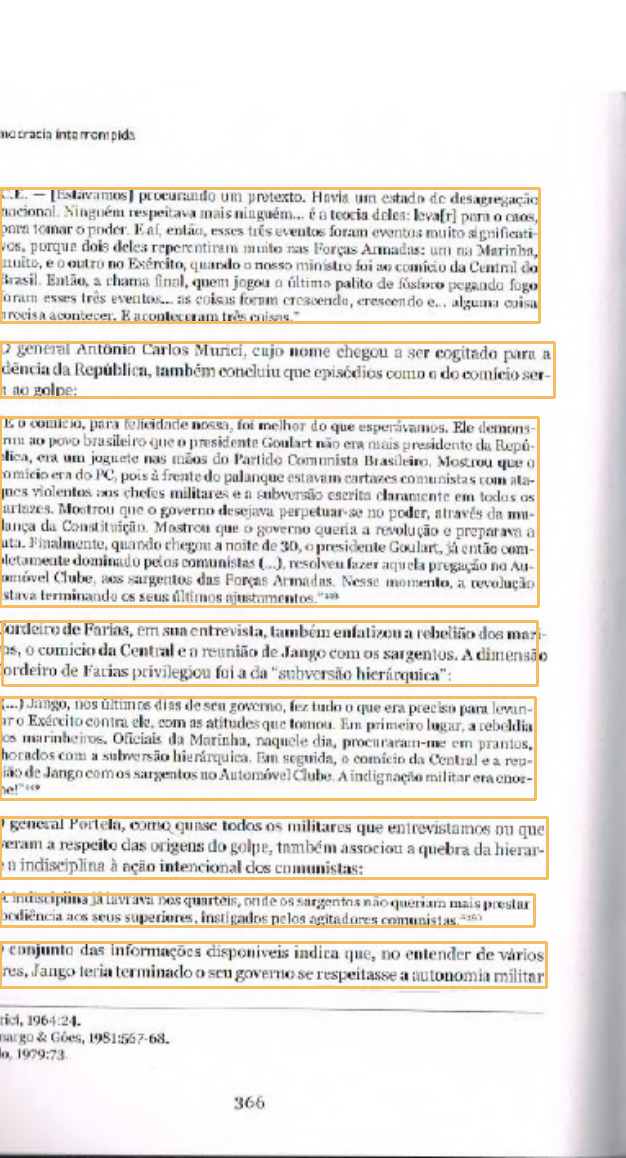

In [211]:
lp.draw_box(page1, layout, box_width=3)